# Deep Dream

In [17]:
import numpy as np

# Zum Löschen der Ausgabe einer Zelle
from IPython.display import clear_output

import matplotlib as mpl
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Normalisiere das Bild
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Bildanzeige
def show(img):
    plt.figure(figsize = (12, 12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

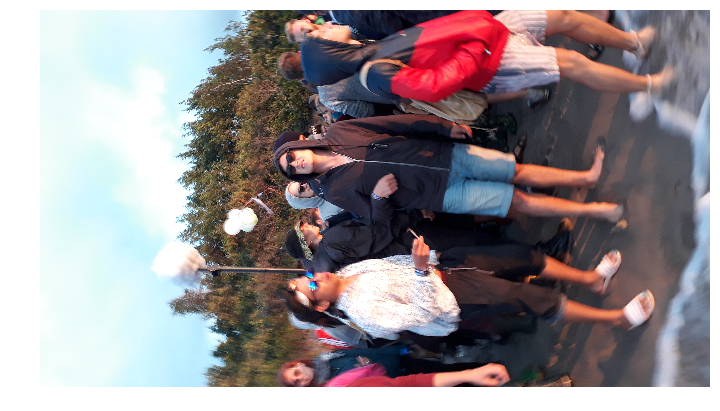

In [18]:
import os
from PIL import Image

basedir='deepdream'
original_image = os.path.join(basedir, "test.jpg")
final_image = os.path.join(basedir, "test_dream.jpg")

original_img = np.array(Image.open(original_image))

show(original_img)

In [19]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model.summary()

87916544/87910968 [==============================] - 10s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________

In [ ]:
# Maximierung der Aktivierung in Layern
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)



In [ ]:
def calculate_loss(img, model):
    # Forward Pass des Bildes durch das Inception_v3, um die Aktivierung zu erhalten
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    
    losses=[]
    
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
        
    return tf.reduce_sum(losses)

@tf.function
def deepdream(model, img, step_size):
    with tf.GradientTape() as tape:
        # Wir brauchen Gradienten relativ zu 'img'
        tape.watch(img)
        loss = calculate_loss(img, model)
        
    # berechne Gradient der Loss in Bezug zu den Bildwerten des Eigabebildes
    gradients = tape.gradient(loss, img)
    
    # normalisiere die Werte des Gradienten
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    
    # Im Gradientenanstieg wird der Loss maximiert, sodass das Eingabebild die Layers immer mehr anregt
    # Das Bild wird modifiziert durch Addition des Gradienten
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)
    
    return loss ,img

def run_deepdream_feedback(model, img, steps=100, step_size=0.01):
    # Kovertierung von uint8 in den Bereich, der von Incption_v3 erwartet wird
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    for step in range(steps):
        loss, img = deepdream(model, img, step_size)
        
        if step % 100 == 0:
            clear_output(wait=true)
            show(deprocess(img))
            print("Step {}, loss {}".format(step, loss))
            
    result = deprocess(img)
    clear_output(wait=True)
    show(result)